In [1]:
import theano as th
import theano.tensor as T
th.config.compute_test_value = 'warn'

import pymc as pm
import pymc3 as pm3
import numpy as np
import matplotlib.pyplot as pl

import warnings
warnings.simplefilter('ignore', UserWarning)

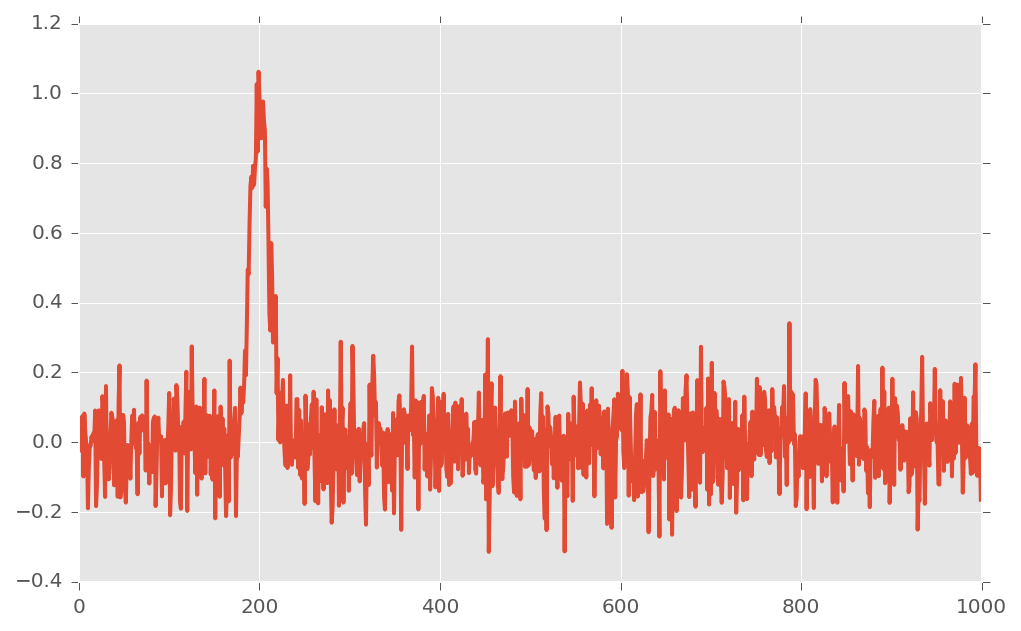

In [36]:
MU = 200
SIGMA = 10
NOISE = 0.1
SAMPLES = 8000
BURN = 2000

X = np.arange(1000)
Y = np.exp(-(X - MU)**2 / (2 * SIGMA**2)) + NOISE * np.random.randn(len(X))
pl.plot(X, Y)
pl.show()

### PyMC2

In [37]:
mu = pm.Uniform('mu', lower=0, upper=len(X))
sigma = pm.Uniform('sigma', lower=1, upper=25)

@pm.deterministic
def gaussian(x=X, mu=mu, sigma=sigma):
     return np.exp(-(x - mu)**2 / (2 * sigma**2))

noise = pm.Uniform('noise', lower=0, upper=1)
obs = pm.Normal('obs', mu=gaussian, tau=1/noise**2, observed=True,
                value=Y)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec

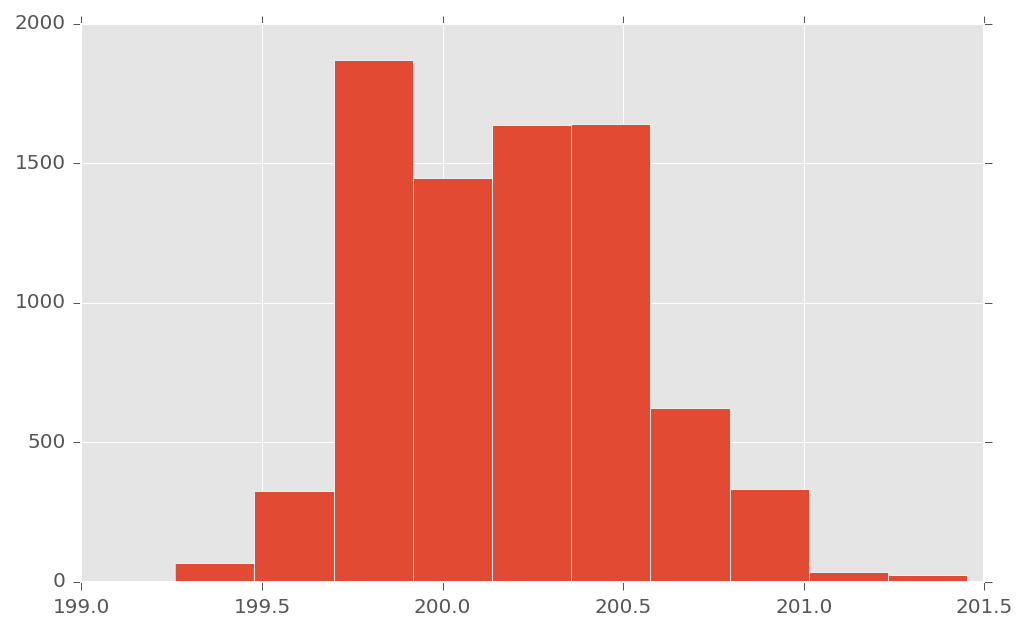

In [38]:
model = pm.Model([mu, sigma, noise, obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

pl.hist(mcmc.trace('mu')[:])
pl.show()

### PyMC3

In [39]:
pm3.Deterministic

<function pymc3.model.Deterministic>

In [48]:
trace.varnames

['mu_interval_', 'sigma_interval_', 'mu', 'sigma']

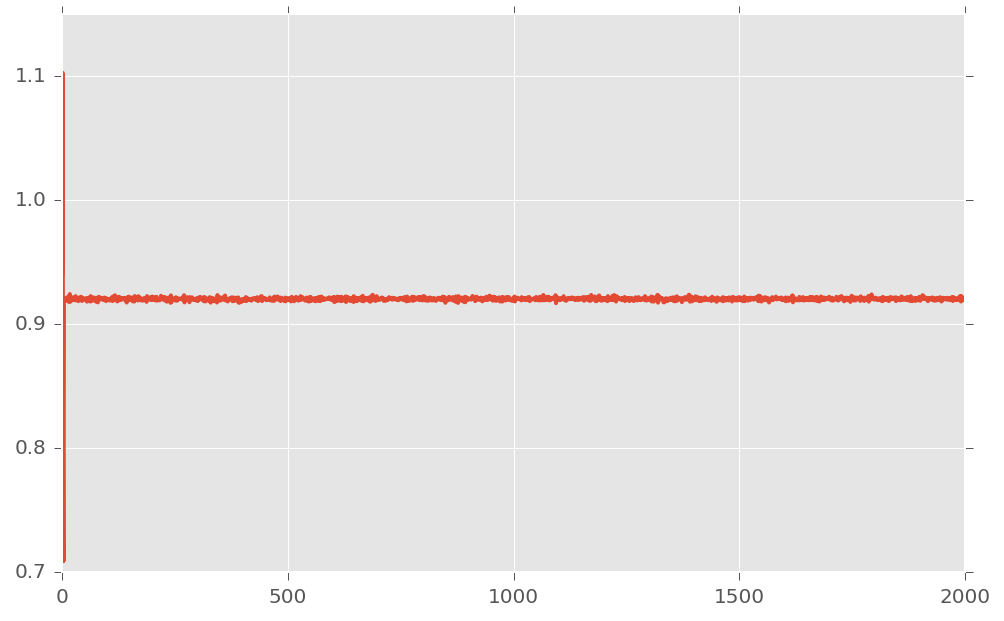

In [49]:
pl.plot(trace.get_values('mu_interval_'))

Applied interval-transform to mu and added transformed mu_interval_ to model.
Applied interval-transform to sigma and added transformed sigma_interval_ to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 10.7 sec

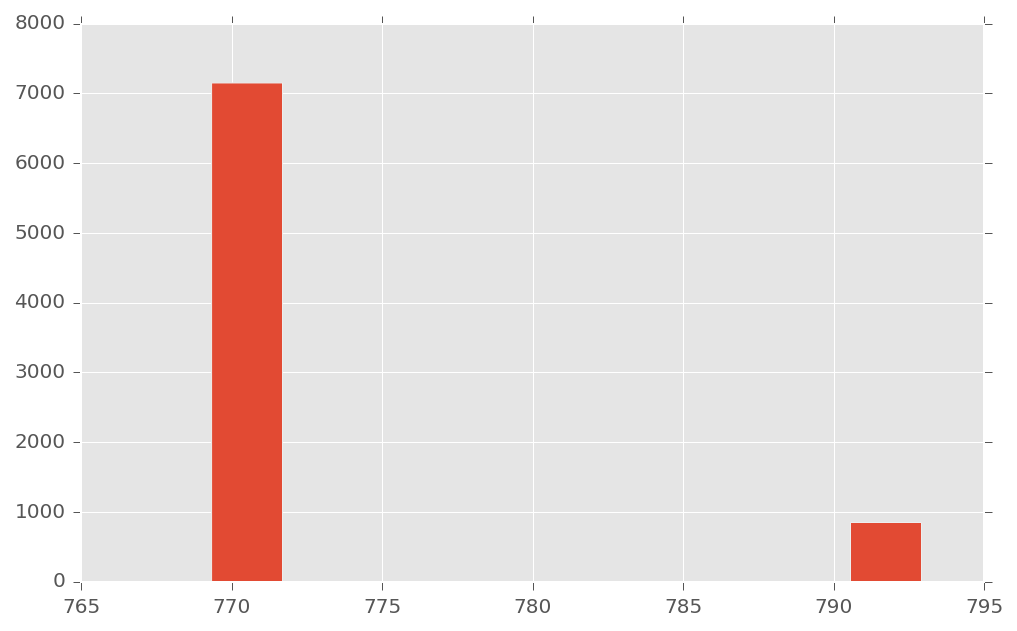

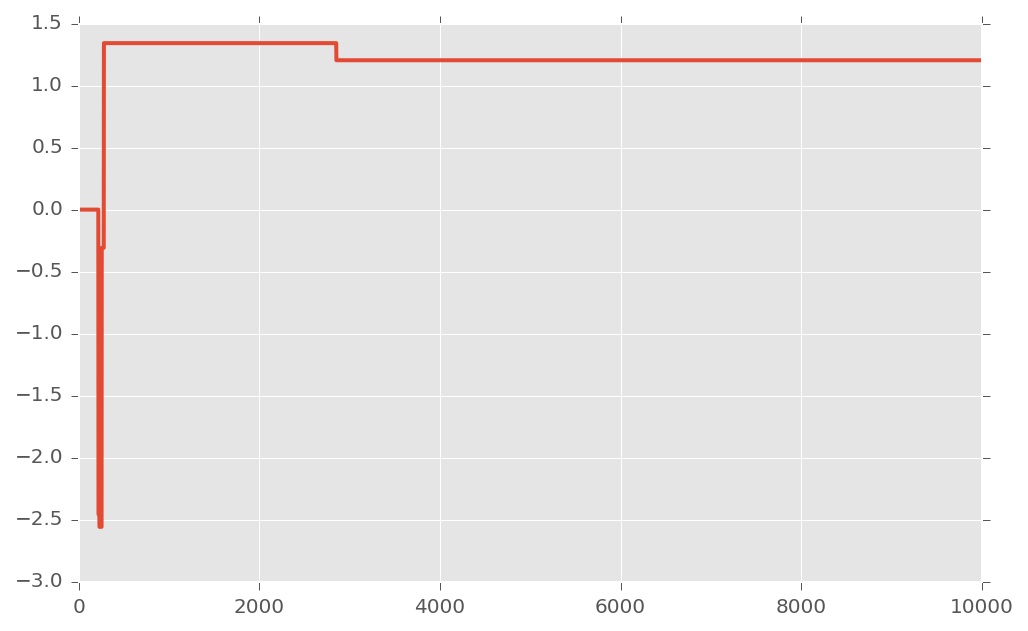

In [66]:
with pm3.Model() as model:
    mu = pm3.Uniform('mu', lower=0, upper=len(X))
    sigma = pm3.Uniform('sigma', lower=1, upper=25)
    #noise = pm3.Uniform('noise', lower=0, upper=1)
    
    x = th.shared(X)
    y = T.exp(- (x - mu)**2 / (2 * sigma**2))

    obs = pm3.Normal('obs', y, tau=1 / NOISE**2, observed=Y)
    
    step = pm3.HamiltonianMC()
    trace = pm3.sample(SAMPLES + BURN, step, progressbar=True)
    
pl.hist(trace.get_values('mu', combine=True, burn=BURN))
pl.show()
pl.plot(trace.get_values('mu_interval_'))
pl.show()

In [ ]:
with model:
    step = pm3.Metropolis()
    trace = pm3.sample(BURN + SAMPLES, step, progressbar=True)
    
pl.hist(trace.get_values('mu', combine=True, burn=BURN))
pl.show()

### QInfer

In [21]:
import qinfer as qi

In [70]:
class GaussianDeconvModel(qi.Model):
    r"""
    Implements the "noisy coin" model of [FB12]_, where the model parameter
    :math:`p` is the probability of the noisy coin. This model has two
    experiment parameters, :math:`\alpha` and :math:`\beta`, which are the
    probabilities of observing a "0" outcome conditoned on the "true" outcome
    being 0 and 1, respectively. That is, for an ideal coin, :math:`\alpha = 1`
    and :math:`\beta = 0`.
    
    Note that :math:`\alpha` and :math:`\beta` are implemented as experiment
    parameters not because we expect to design over those values, but because
    a specification of each is necessary to honestly describe an experiment
    that was performed.
    """
        
    ## PROPERTIES ##
    
    @property
    def n_modelparams(self):
        return 1
        
    @property
    def expparams_dtype(self):
        return [('alpha','float'), ('beta','float')]
    
    @property
    def is_n_outcomes_constant(self):
        return True
    
    ## METHODS ##
    
    @staticmethod
    def are_models_valid(modelparams):
        return np.logical_and(modelparams >= 0, modelparams <= 1).all(axis=1)
    
    def n_outcomes(self, expparams):
        return 2
    
    def likelihood(self, outcomes, modelparams, expparams):
        # Unpack alpha and beta.
        a = expparams['alpha']
        b = expparams['beta']
        
        # Find the probability of getting a "0" outcome.
        pr0 = modelparams * a + (1 - modelparams) * b
        
        # Concatenate over outcomes.
        return qi.Model.pr0_to_likelihood_array(outcomes, pr0)

In [82]:
model = GaussianDeconvModel()
prior = qi.distributions.UniformDistribution([0, 1])

N_PARTICLES = 10000
N_EXP = 2500

ALPHA = 0.1
BETA = 0.8
expparams = np.array([(ALPHA, BETA)], dtype=model.expparams_dtype)

In [83]:
updater = qi.smc.SMCUpdater(model, N_PARTICLES, prior)
truemp = np.array([[0.6]])

for _ in range(N_EXP):
    outcome = model.simulate_experiment(truemp, expparams)
    updater.update(outcome, expparams)

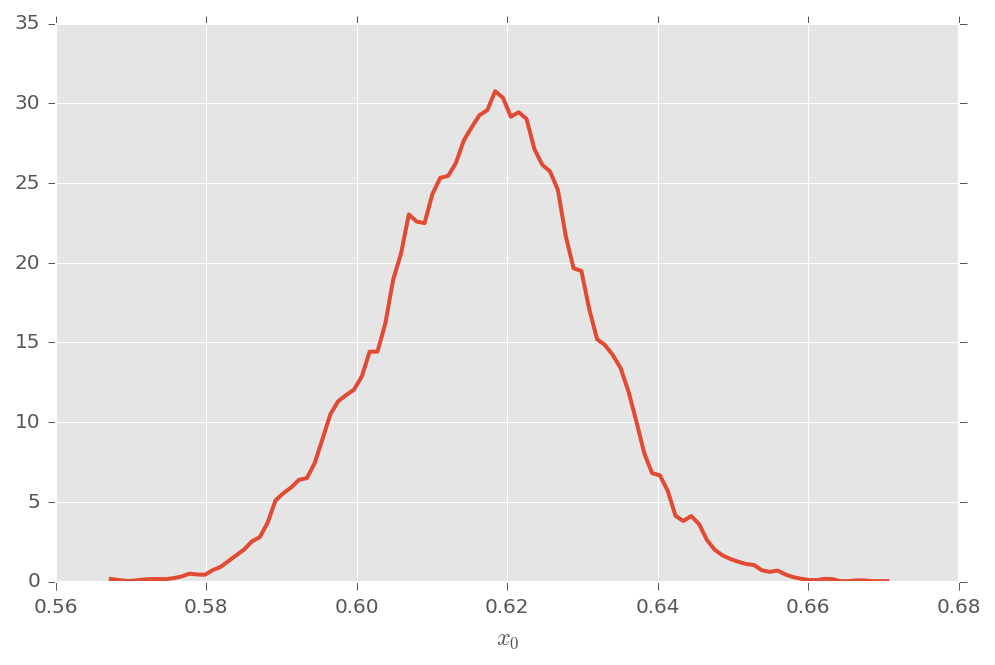

In [84]:
updater.plot_posterior_marginal()

In [ ]:
MU